## Install packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import NMF
from numpy import asarray
from numpy import savetxt
import matplotlib.colors as mcolors
import matplotlib.cm
import matplotlib.patches as mpatches
import umap
import matplotlib as mpl
import scanpy as sc
import scipy
import kmapper as km
from kmapper import jupyter
from kmapper.plotlyviz import plotlyviz
from kmapper.plotlyviz import *
import plotly.graph_objs as go
import sys
from sklearn import ensemble
from tqdm import tqdm
from ripser import Rips
from ripser import ripser
from persim import plot_diagrams
from sklearn.metrics.pairwise import euclidean_distances

## Read in data

In [2]:
pd_data = pd.read_csv("cell_cycle.csv", sep=',', header = 0, index_col = 0) 
np_data = np.array(pd_data)

In [3]:
pd_data

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000286234,ENSG00000286235,ENSG00000286237,ENSG00000286239,ENSG00000286243,ENSG00000286255,ENSG00000286261,ENSG00000286264,ENSG00000286265,ENSG00000286268
A10_355,31.44,0.0,108.00,5.02,11.69,0.0,0.00,24.99,7.74,16.25,...,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,6.05
A10_356,45.47,0.0,34.09,0.00,18.93,0.0,0.00,11.14,16.90,4.35,...,0.0,1.02,0.0,10.41,0.0,0.0,3.56,0.0,0.0,0.00
A10_357,8.79,0.0,97.98,0.00,24.30,0.0,0.00,66.16,27.88,20.81,...,0.0,0.54,0.0,0.00,0.0,0.0,2.88,0.0,0.0,0.00
A11_355,27.14,0.0,69.77,0.49,33.56,0.0,0.00,9.23,7.59,23.10,...,0.0,0.00,0.0,6.30,0.0,0.0,0.00,0.0,0.0,0.00
A11_356,129.83,0.0,37.72,6.50,5.55,0.0,0.00,47.08,16.90,14.69,...,0.0,0.00,0.0,12.21,0.0,0.0,0.00,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P8_356,21.52,0.0,70.02,7.23,13.10,0.0,0.00,43.42,10.12,22.11,...,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00
P8_357,48.58,0.0,70.27,0.54,48.05,0.0,0.00,26.30,11.02,19.82,...,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00
P9_355,69.57,0.0,60.75,7.52,18.89,0.0,10.84,86.98,0.00,7.45,...,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00
P9_356,60.22,0.0,50.06,0.00,12.25,0.0,0.00,29.76,15.65,8.23,...,0.0,0.00,0.0,1.11,0.0,0.0,0.00,0.0,0.0,0.00


In [4]:
reducer = umap.UMAP()
UMAP = reducer.fit_transform(np_data.T)
print(UMAP.shape)

#savetxt('cellcycle_umap.csv', UMAP, delimiter=',')

(42728, 2)


In [5]:
UMAP = pd.read_csv("cellcycle_umap.csv", sep=',', header = None)
UMAP = UMAP.values 

print("UMAP shape: "+repr(UMAP.shape))

UMAP shape: (42728, 2)


No handles with labels found to put in legend.


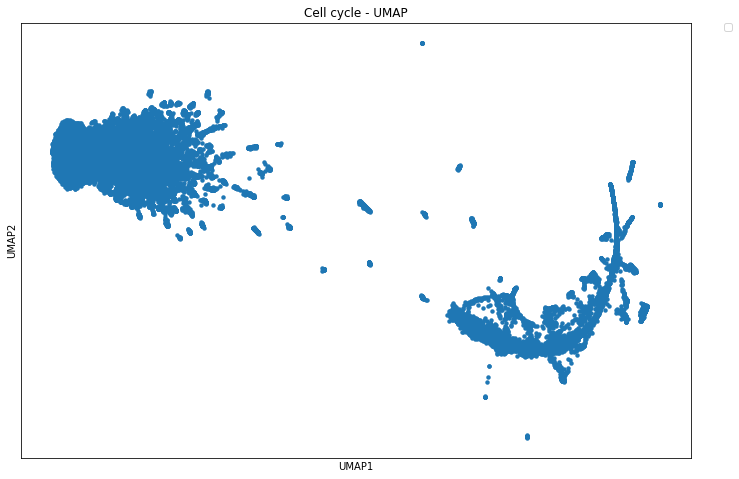

In [6]:
plt.figure(figsize=(12, 8))
frame1 = sns.scatterplot(UMAP[:,0], UMAP[:,1], s=20,  linewidth = 0)
plt.title('Cell cycle - UMAP')
#plt.xlim(-30000,25000)
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## Distance Matrix

In [7]:
from manifold_utils.mSVD import eigen_plot, eigen_calc_from_dist_mat, eps_projection

In [8]:
np_data = np_data.T
N, d = np_data.shape
 
dist_mat = euclidean_distances(np_data, np_data)

In [9]:
#savetxt('dist_mat_cellcycle.csv', dist_mat, delimiter=',')

#dist_mat = pd.read_csv('dist_mat_cellcycle.csv', sep=",", header = None)
#dist_mat = np.array(dist_mat )

In [10]:
print(dist_mat.shape)

(42728, 42728)


## Visualize Landmarks

In [11]:
from time import time
import numpy as np
from tda_utils.density_filtration import sort_distances_per_point, indices_for_density_filtration
from tda_utils.witness_complex import *

dist_per_pt = sort_distances_per_point(dist_mat)

# Load in ILC data
sct_sparse = np_data
dist_mat = dist_mat
n, d = sct_sparse.shape
print("n = "+str(n))
print("d = "+str(d))
print("shape of dist_mat: "+str(dist_mat.shape))

# Load in distances per point
distances_per_point = dist_per_pt

# time computation of density filtrations
print("Timing computation of density filtrations...")
density_indices = dict()
density_filtrations = dict()
ks = [10, 100, 1000]
#      10000]
ps = [0.01, 0.05, 0.1, 0.2]
for k in ks:
    for p in ps:
        print("\tk = "+str(k)+", p = "+str(p)+":")
        start = time()
        indices = indices_for_density_filtration(distances_per_point, k, p)
        density_indices[(k, p)] = indices
        mask = np.zeros(n, dtype=bool)
        mask[indices] = True
        sqr_mask = np.outer(mask, mask)
        density_filtrations[(k, p)] = np.reshape(dist_mat[sqr_mask], (len(indices), len(indices)))
        print("\t"+str(time()-start)+" seconds\n")

print("Timing computation of landmarks...")
landmark_indices = dict()
landmark_mats = dict()
pps = [0.05, 0.1, 0.2]
for k in ks:
    for p in ps:
        for pp in pps:
            print("\tk = "+str(k)+", p = "+str(p)+", pp = "+str(pp)+":")
            start = time()
            landmark_indices[(k, p, pp)], landmark_mats[(k, p, pp)] = choose_landmarks(density_filtrations[(k, p)], pp)
            print("\t"+str(time()-start)+" seconds\n")

print("Printing numbers of landmarks...")
for k in ks:
    for p in ps:
        for pp in pps:
            toople = (k, p, pp)
            print(str(toople)+": "+str(len(landmark_indices[toople])))
            if toople == (1000, 0.2, 0.2):
                print("saving")
                landmark_inds = landmark_indices[toople]
                dense_inds = density_indices[(k, p)]
                true_inds = [dense_inds[ind] for ind in landmark_inds]
                print(true_inds)
                to_save = np.vstack([sct_sparse[ind, :] for ind in true_inds])
                np.save("PanSquam_landmarks.npy", to_save)
                np.save("PanSquam_Racute_landmark_indices.npy", true_inds)

n = 42728
d = 1152
shape of dist_mat: (42728, 42728)
Timing computation of density filtrations...
	k = 10, p = 0.01:
	1.7478759288787842 seconds

	k = 10, p = 0.05:
	1.955221176147461 seconds

	k = 10, p = 0.1:
	2.1562209129333496 seconds

	k = 10, p = 0.2:
	3.443699598312378 seconds

	k = 100, p = 0.01:
	1.957956314086914 seconds

	k = 100, p = 0.05:
	1.9637176990509033 seconds

	k = 100, p = 0.1:
	2.1980972290039062 seconds

	k = 100, p = 0.2:
	3.438422918319702 seconds

	k = 1000, p = 0.01:
	1.911062479019165 seconds

	k = 1000, p = 0.05:
	2.080143451690674 seconds

	k = 1000, p = 0.1:
	2.279707431793213 seconds

	k = 1000, p = 0.2:
	3.3215208053588867 seconds

Timing computation of landmarks...
	k = 10, p = 0.01, pp = 0.05:
	0.0009999275207519531 seconds

	k = 10, p = 0.01, pp = 0.1:
	0.0 seconds

	k = 10, p = 0.01, pp = 0.2:
	0.0009310245513916016 seconds

	k = 10, p = 0.05, pp = 0.05:
	0.002980947494506836 seconds

	k = 10, p = 0.05, pp = 0.1:
	0.004000425338745117 seconds

	k = 

In [12]:
landmarks = np.load("PanSquam_landmarks.npy")

landmarks = true_inds
print(true_inds)

[18520, 21011, 29974, 30956, 20911, 24495, 27361, 34971, 18343, 17741, 38921, 18856, 28763, 37373, 33297, 18316, 24792, 28114, 34029, 35395, 23799, 31381, 33336, 31701, 15447, 12910, 24816, 29835, 18585, 28605, 29541, 23533, 18190, 10860, 21027, 20694, 13428, 17942, 27315, 21515, 38818, 30259, 21186, 15051, 27790, 21033, 20175, 27530, 29811, 30214, 21595, 35867, 33859, 38567, 38326, 30713, 37163, 18149, 19682, 24151, 40560, 22737, 22694, 26422, 19195, 18541, 23121, 39831, 38031, 23869, 3663, 34007, 33613, 20465, 26677, 35636, 31500, 30398, 29321, 27202, 32001, 38992, 36979, 39441, 36187, 39868, 18941, 34269, 38089, 18092, 34974, 23859, 28171, 23055, 13156, 21980, 9074, 23207, 24858, 28370, 13718, 18226, 34023, 36898, 37958, 30082, 31903, 18545, 28678, 36919, 26486, 17786, 18659, 27911, 33168, 17940, 18577, 24069, 38367, 28849, 32670, 33095, 24839, 17987, 33177, 31267, 18594, 13246, 29656, 33840, 19568, 23297, 26766, 35692, 35291, 33712, 29875, 26737, 11958, 18643, 5650, 24906, 39817, 3

In [13]:
N, d = np_data.shape
genes = pd_data.columns

UMAP = np.array(UMAP)
print(UMAP.shape)

UMAP_landmark = np.zeros((1,2))
data_landmark = np.zeros((1,d))

#Going through all of the cells, if index in landmarks we should pull the associated gene expression data
for i in landmarks:
    next_cell = np_data[i,:]
    next_cell = np.reshape(next_cell, (1, d))
    data_landmark = np.append(data_landmark, next_cell, axis = 0)
        
    next_embedding = UMAP[i,:]
    next_embedding = np.reshape(next_embedding, (1,2))
    UMAP_landmark = np.append(UMAP_landmark, next_embedding, axis = 0)

#To get the indices to work out I have a row of zeros at the top that I need to omit
data_landmark = data_landmark[1:, :]    
UMAP_landmark = UMAP_landmark[1:, :]

print(data_landmark.shape)
print(UMAP_landmark.shape)

(42728, 2)
(1709, 1152)
(1709, 2)


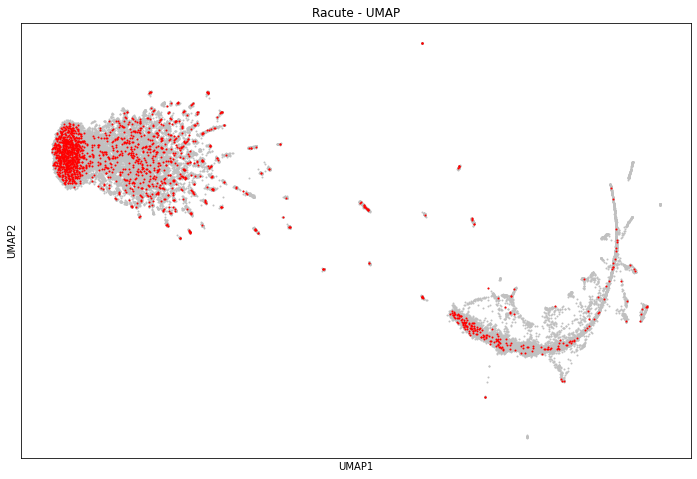

In [14]:
plt.figure(figsize=(12, 8))
frame1 = plt.scatter(UMAP[:,0], UMAP[:,1], s=1, c = "silver")
frame1 = plt.scatter(UMAP_landmark[:,0], UMAP_landmark[:,1], s=1, c = "red")
plt.title('Racute - UMAP')
#plt.xlim(-30000,25000)
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')
plt.show()

## Persistence Diagrams

In [15]:
#rips = Rips()
#diagrams = rips.fit_transform(dist_mat, distance_matrix=True, metric="euclidean")
#rips.plot(diagrams)

## Eigen plots

In [16]:
from manifold_utils.mSVD import eigen_plot, eigen_calc_from_dist_mat, eps_projection, eigen_plot_numPoints, eigen_calc_from_dist_mat_withNumPoints
from manifold_utils.iga import chakraborty_express, iga

  0%|                                                                                         | 0/1709 [00:00<?, ?it/s]

24812


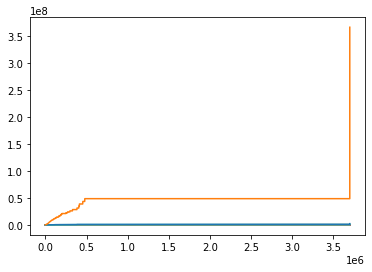

  0%|                                                                           | 1/1709 [18:29<526:32:36, 1109.81s/it]

40019


  0%|                                                                           | 1/1709 [31:00<882:28:47, 1860.03s/it]


KeyboardInterrupt: 

In [17]:
for i in tqdm(range(len(landmarks))):
    print(landmarks[i])
    center = landmarks[i]
    radii, eigval_list, eigvec_list = eigen_calc_from_dist_mat(np_data, dist_mat, center, radint = 10)

    rmin = radii[0]
    rmax = radii[-1]
    
    eigen_plot(eigval_list, radii, rmin, rmax)

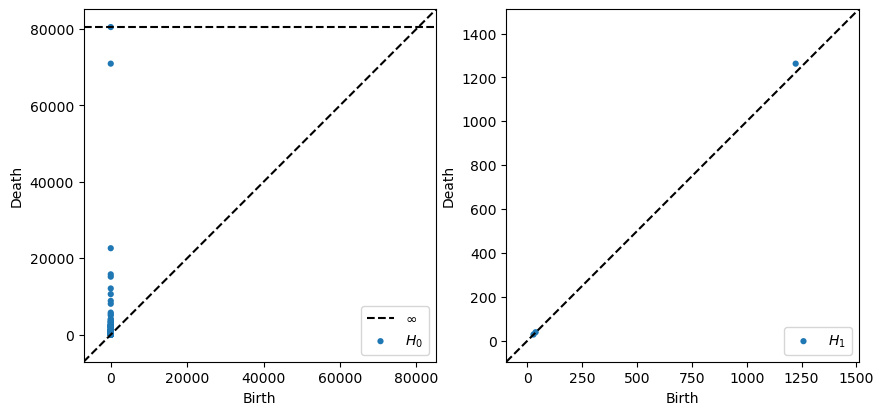

In [18]:
dgms = ripser(data_landmark, maxdim=1)['dgms']


plt.figure(figsize=(10, 5))
plot_diagrams(dgms, plot_only=[0], ax=plt.subplot(121))
plot_diagrams(dgms, plot_only=[1], ax=plt.subplot(122))

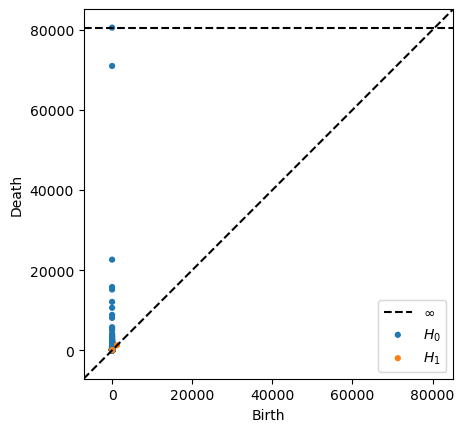

In [20]:
plot_diagrams(dgms, show=True)

In [15]:
data_landmark.shape

(1709, 1152)

In [16]:
np_data.shape

(42728, 1152)

In [ ]:
dgms = ripser(np_data, maxdim=1)['dgms']


plt.figure(figsize=(10, 5))
plot_diagrams(dgms, plot_only=[0], ax=plt.subplot(121))
plot_diagrams(dgms, plot_only=[1], ax=plt.subplot(122))